<a href="https://colab.research.google.com/github/PatrickSampaioUSP/Propy/blob/master/PropGoverningEquations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$r = aP^n$

In [0]:
class PressureOutOfBoundException(Exception):
  pass

class KnsbBurnrate:

  @classmethod
  def pressure_coefficient(cls, pressure):
    pressure_coefficient = 0
    if .101 <= pressure < .807:
      pressure_coefficient = 10.708
    elif .807 <= pressure < 1.503:
      pressure_coefficient = 8.763
    elif 1.503 <= pressure < 3.792:
      pressure_coefficient = 7.852
    elif 3.792 <= pressure < 7.033:
      pressure_coefficient = 3.907
    elif 7.033 <= pressure < 10.67:
      pressure_coefficient = 9.653
    else:
      raise PressureOutOfBoundException

    return pressure_coefficient

  @classmethod
  def pressure_exponential_coef(cls, pressure):
    pressure_exponential_coeficient = 0
    if .101 <= pressure < .807:
      pressure_exponential_coeficient = .625
    elif .807 <= pressure < 1.503:
      pressure_exponential_coeficient = -.314
    elif 1.503 <= pressure < 3.792:
      pressure_exponential_coeficient = -.013
    elif 3.792 <= pressure < 7.033:
      pressure_exponential_coeficient = .535
    elif 7.033 <= pressure < 10.67:
      pressure_exponential_coeficient = .064
    else:
      raise PressureOutOfBoundException

    return pressure_exponential_coeficient

  @classmethod
  def calculate_burnrate(cls, pressure):
    pressure_coef = cls.pressure_coefficient(pressure)
    pressure_exponential_coef = cls.pressure_exponential_coef(pressure)

    return pressure_coef*pressure**pressure_exponential_coef


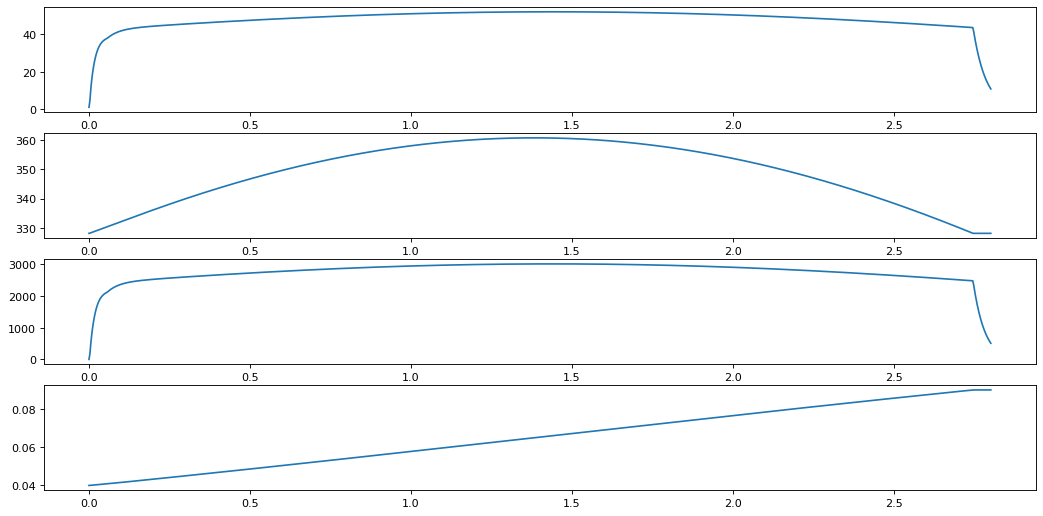

Empuxo máximo 3007.9 N
Pressão média 52.15 bar
Empuxo médio 2749.92 N
Pressão média 48.04 bar
Taxa de queima média 8.92 mm/s
Tempo de queima 2.8 s


In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

############ Parameters #############
k = 1.1362                                            #Razão de calores específicos
rho_grain = 1700.                                     #Densidade do grão (kg/m^3)
burn_rate = 7.72/1000                                 #Taxa de queima (m/s)
cstar = 816.68                                        #Velocidade característica (m/s)
r_throat = 12/1000                                    #Raio da garganta do bocal (m)
throat_area = math.pi*r_throat**2                     #Area da garganta do bocal (m^2)
D0 = 90./1000                                         #Diâmetro externo inicial (m)
N = 5                                                 #Número de grãos
R_universal = 8.314*(10**3)                           #Constante universal dos gases (J/(kg K))
Mm = 39.9                                             #Massa molecular efetiva dos produtos de combustão (kg/kmol)
R = R_universal/Mm                                    #Constante dos produtos de combustão
T = 1600.                                             #Temperatura de combustão (K)
d0 = 40./1000                                         #Diâmetro interno inicial (m)
Lgrain = (3*D0 + d0)/2                                #Comprimento do grão (tamanho ideal de grão para curva Kn simétrica) (m)
w0 = (D0-d0)/2                                        #Espessura inicial do grão (m)
p_atm = 1.01325*(10**5)                               #Pressão atmosférica (Pa)
m_prod_chamber = 0.                                   #Massa dos produtos de combustão (kg)
L_chamber = N*Lgrain                                  #Comprimento de câmara (m)
D_chamber = 104./1000                                 #Diâmetro interno da câmara (m)
chamber_volume = L_chamber*math.pi*(D_chamber**2)/4   #Volume inicial de câmara (m^3)
n_cf = 0.8                                            #Eficiência do coeficiente de empuxo




################## FUNCOES ##################

calculate_pressure_steady = lambda x: x*rho_grain*burn_rate*cstar
calculate_nozzle_mass_flow = lambda x: x*throat_area*math.sqrt(k/(R*T))*math.pow((2/(k+1)),((k+1)/(2*(k-1))))
calculate_cf = lambda x: math.sqrt((2*k**2/(k-1))*((2/(k+1))**((k+1)/(k-1)))*(1-(p_atm/x)**((k-1)/k)))

def calculate_current_prop_volume(grain_number, lgrain, d_ext, d_in):
  propelent_volume = grain_number*(((d_ext**2 - d_in**2)/4)*math.pi*lgrain)
  return propelent_volume

def calculate_current_burn_area(d_ext, d_in, lgrain, n):
  transversal_area = math.pi*(d_ext**2-d_in**2)*n/2
  longitudinal_area = math.pi*lgrain*d_in*n
  return longitudinal_area + transversal_area

############### MODELO #################

def modelo(y, t):
    #d0 
    #lgrain
    #pressure
    #chamber combustion product mass
    ydot = [0, 0, 0, 0]
    if D0 > y[0]:
      burn_rate = (10**-3)*KnsbBurnrate.calculate_burnrate(y[2]/(10**6))
    else:
      burn_rate = 0
    ydot[0] = 2*burn_rate
    ydot[1] = -1*ydot[0]
    current_prop_volume = calculate_current_prop_volume(N, y[1], D0, y[0])
    free_volume = chamber_volume - current_prop_volume
    rho_o = y[3]/free_volume

    burn_area = calculate_current_burn_area(D0, y[0], y[1], N)
    
    # massa que esta saindo dos grãos
    m_dot = burn_area*rho_grain*burn_rate
    nozzle_mass_flow = calculate_nozzle_mass_flow(y[2])
    ydot[3] = m_dot - nozzle_mass_flow
    ydot[2] = ((R*T)/free_volume) * (burn_area*burn_rate*(rho_grain-rho_o) - nozzle_mass_flow)
    return ydot

def solve(func, conditions, t):
    #par = tuple(i for i in conditions[1:])
    Y = odeint(func, conditions, t)
    return Y

conditions = [d0, Lgrain, p_atm, m_prod_chamber]
t = np.linspace(0,2.8,1000)
y = solve(modelo, conditions, t)

pressure_list = list(map(lambda x: x/10**5, y[:,2]))
mass_in_chamber_list = y[:,3]
grain_length = y[:,1]
grain_ext_d = y[:,0]


calculate_thrust = lambda C,x: C*throat_area*x
cf=np.zeros(len(pressure_list))
thrust_list = np.zeros(len(cf))
burn_rate_list = np.zeros(len(cf))
#print(grain_ext_d[-1])

for j in range(len(pressure_list)):
  cf[j]=n_cf*calculate_cf(pressure_list[j]*10**5)
  thrust_list[j]=calculate_thrust(cf[j],pressure_list[j]*10**5)
  burn_rate_list[j] = modelo(y[j,:],t)[0]*1000/2

average_burn_rate = np.mean(burn_rate_list)
burn_time = w0*1000/average_burn_rate

#cf = calculate_cf(np.mean(y[:,2]))
#thrust_list = list(map(lambda x: calculate_thrust(x), y[:,2]))

kn_list = list(map(lambda x: calculate_current_burn_area(D0, x[0], x[1], N)/throat_area, zip(grain_ext_d, grain_length)))

plt.figure(figsize=(16,8),dpi=80)
plt.subplot(4,1,1)
plt.plot(t,pressure_list)
plt.subplot(4,1,2)
plt.plot(t,kn_list)
plt.subplot(4,1,3)
plt.plot(t,thrust_list)
plt.subplot(4,1,4)
plt.plot(t,grain_ext_d)
plt.show()

print(f"Empuxo máximo {round(np.max(thrust_list), 2)} N")
print(f"Pressão média {round(np.max(pressure_list), 2)} bar")
print(f"Empuxo médio {round(np.mean(thrust_list), 2)} N")
print(f"Pressão média {round(np.mean(pressure_list), 2)} bar")
print(f"Taxa de queima média {round(average_burn_rate, 2)} mm/s")
print(f"Tempo de queima {round(burn_time, 2)} s")


Pendencias:

- $\dot{M}_{nozzle}$ (check)
- $V_{camara}$ (check)
- $T_{combustion}$ (check)
- $R = \frac{\bar{R}}{M_M}$ (check)
- Tempo de queima e tail-off (check)
- $C_f$ variável com altidude
- Impulso total